# Import ~ Seed 선언

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Input
from keras.optimizers import Adam
from keras import initializers

import os
import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Keras 가 Tensorflow 를 벡엔드로 사용할 수 있도록 설정합니다.
os.environ["KERAS_BACKEND"] = "tensorflow"

# 실험을 재현하고 동일한 결과를 얻을 수 있는지 확인하기 위해 seed 를 설정합니다.
seed = 2019
np.random.seed(seed)
tf.set_random_seed(seed)

# Data Preprocessing

## 데이터셋 불러오기

In [3]:
# 데이터셋 로드
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
secom = pd.read_csv(url, header=None, delim_whitespace=True)
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"
y = pd.read_csv(url, header=None, usecols=[0], squeeze=True, delim_whitespace=True) 
# delim_whitespace = True : 빈 공간(' ')을 구분자로 인식하고 데이터 읽어옴
# squeeze 만약 컬럼 하나만 읽어오면 데이터 구조를 Series로 읽어옴

In [4]:
print(type(secom)) # 데이터 구조: DataFrame
print(secom.shape) # 1567개의 인스턴스 590개의 속성
secom.head()

<class 'pandas.core.frame.DataFrame'>
(1567, 590)


,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


## 데이터셋 파악

In [5]:
print('The dataset has {} observations/rows and {} variables/columns.'.format(secom.shape[0], secom.shape[1]))
print('The majority class has {} observations, minority class {}.'.format(y[y == -1].size, y[y == 1].size))
print('The dataset is imbalanced. The ratio of majority class to minority class is {%.2f}:1.' % (float(y[y == -1].size/y[y == 1].size)))

The dataset has 1567 observations/rows and 590 variables/columns.
The majority class has 1463 observations, minority class 104.
The dataset is imbalanced. The ratio of majority class to minority class is {14.07}:1.


In [6]:
# 결측치를 가지고 있는 컬럼이 몇 개 인지 확인하는 코드

nmv = secom.dropna(axis=1) # 열을 기준으로 NaN 값이 존재하면 그 열을 삭제하고 반환
print('No. of columns after removing columns with missing data: {}'.format(nmv.shape[1]))

nmv = secom.dropna(axis=0) # 행을 기준으로 NaN 값이 존재하면 그 열을 삭제하고 반환
print('No. of rows after removing rows with missing data: {}'.format(nmv.shape[0]))

del nmv # nmv 변수는 오류 방지를 위해 확인 후 바로 삭제

No. of columns after removing columns with missing data: 52
No. of rows after removing rows with missing data: 0


## 상수 값을 가지는 열 제거

In [7]:
dropthese = [i for i in range(590) if secom[i].std() == 0]
secom_categorical = secom.drop(dropthese, axis = 1)
print(secom_categorical.shape)
secom_categorical.head()

print('There are {} columns which have identical values recorded. We will drop these.'.format(len(dropthese)))
print('The data set now has {} columns.'.format(secom_categorical.shape[1]))

(1567, 474)
There are 116 columns which have identical values recorded. We will drop these.
The data set now has 474 columns.


## 결측치 확인 

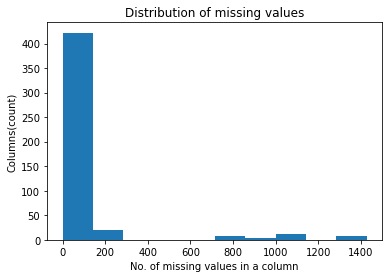

In [8]:
# 결측치 파악을 위한 히스토그램 출력
secom_categorical = pd.DataFrame(secom_categorical)
feature_names = secom_categorical.columns

m = list((map(lambda i: sum(secom_categorical[i].isnull()), feature_names)))
plt.hist(m)
plt.title("Distribution of missing values")
plt.xlabel("No. of missing values in a column")
plt.ylabel("Columns(count)")
plt.show()

In [9]:
# 결측치 파악을 위한 문구 출력
criteria_list = [100, 200, 400, 500, 600, 700, 800, 900, 1000]

for criteria in criteria_list :
    columns_filtered = list(filter(lambda i: sum(secom_categorical[i].isnull()) > criteria, secom_categorical.columns))
    print('The number of columns with more than {:>4d} missing values(about {}%): {:>2d}'.format(criteria, int((criteria/1253)*100), len(columns_filtered)))

The number of columns with more than  100 missing values(about 7%): 52
The number of columns with more than  200 missing values(about 15%): 52
The number of columns with more than  400 missing values(about 31%): 32
The number of columns with more than  500 missing values(about 39%): 32
The number of columns with more than  600 missing values(about 47%): 32
The number of columns with more than  700 missing values(about 55%): 32
The number of columns with more than  800 missing values(about 63%): 24
The number of columns with more than  900 missing values(about 71%): 24
The number of columns with more than 1000 missing values(about 79%): 20


## 결측치 제거 

In [10]:
# 결측치가 criteria(200)을 초과하는 열을 추출해내는 함수
def get_columns_over_200NaN(df) :
    criteria = 200
    filtered_columns = list(filter(lambda i: sum(df[i].isnull()) > criteria, df.columns))
    return filtered_columns

# main
filtered_columns = get_columns_over_200NaN(secom_categorical)
secom_categorical = secom_categorical.drop(filtered_columns, 1)

print(secom_categorical.shape)
secom_categorical.head()

(1567, 422)


,0,1,2,3,4,6,7,8,9,10,...,576,577,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,97.6133,0.1242,1.5005,0.0162,-0.0034,...,1.6765,14.9509,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,102.3433,0.1247,1.4966,-0.0005,-0.0148,...,1.1065,10.9003,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,95.4878,0.1241,1.4436,0.0041,0.0013,...,2.0952,9.2721,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,104.2367,0.1217,1.4882,-0.0124,-0.0033,...,1.7585,8.5831,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.3967,0.1235,1.5031,-0.0031,-0.0072,...,1.6597,10.9698,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


## 데이터셋 분리

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(secom_categorical, y, test_size = 0.2)

In [12]:
# ndarray 
print(X_train.shape) # (1253, 474)
print(X_test.shape) # (314, 474)
print(y_train.shape) # (1253,)
print(y_test.shape) # (314,)

(1253, 422)
(314, 422)
(1253,)
(314,)


## 결측치 재확인

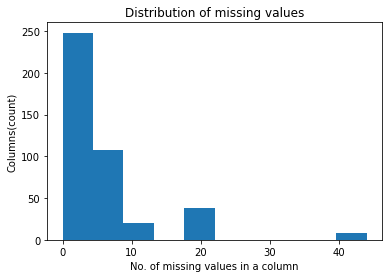

In [13]:
# 결측치 파악을 위한 히스토그램 출력
df_X_train = pd.DataFrame(X_train)
feature_names = df_X_train.columns

m = list((map(lambda i: sum(df_X_train[i].isnull()), feature_names)))
plt.hist(m)
plt.title("Distribution of missing values")
plt.xlabel("No. of missing values in a column")
plt.ylabel("Columns(count)")
plt.show()

## 결측치 채우기 (by Gaussian Distribution)

In [14]:
# fill_NaN_by_Gaussian 함수를 적용하기 위해 데이터 형변환 (ndarray -> DataFrame)
df_X_train = pd.DataFrame(X_train)
df_X_test = pd.DataFrame(X_test)
print(df_X_train.shape)
print(df_X_test.shape)

(1253, 422)
(314, 422)


In [15]:
def fill_NaN_by_Gaussian(df_X_train, df_X_test) :
      
    """결측치를 해당 열의 가우시안 분포를 따르는 난수로 대체하는 함수이다.
       단, test셋의 각 열은 train셋의 각 열의 가우시안 분포를 따른다고 가정한다.
       따라서, test셋은 train셋의 mean, std를 사용한다.                      """
    
    for column in df_X_train.columns.values : 
        
        mean = df_X_train[column].mean()
        std = df_X_train[column].std()
            
        X_train_NaN_size = sum(df_X_train[column].isnull())
        X_test_NaN_size = sum(df_X_test[column].isnull())
          
        df_X_train.loc[df_X_train[column].isnull(), column] = np.random.normal(mean, std, size = X_train_NaN_size)            
        df_X_test.loc[df_X_test[column].isnull(), column] = np.random.normal(mean, std, size = X_test_NaN_size)

    return (df_X_train, df_X_test)
                          
                          
# main
df_X_train, df_X_test = fill_NaN_by_Gaussian(df_X_train, df_X_test)
print(df_X_train.shape)       
print(df_X_test.shape)

(1253, 422)
(314, 422)


In [16]:
# 결측치를 채우고 난 후 정상적으로 결측치가 채워졌는지 재확인하는 코드

# df_X_train
nmv = df_X_train.dropna(axis=1) # 열을 기준으로 NaN 값이 존재하면 그 열을 삭제하고 반환
print('No. of columns after removing columns with missing data: {}'.format(nmv.shape[1]))

nmv = df_X_train.dropna(axis=0) # 행을 기준으로 NaN 값이 존재하면 그 열을 삭제하고 반환
print('No. of rows after removing rows with missing data: {}'.format(nmv.shape[0]))

del nmv  # nmv 변수는 오류 방지를 위해 확인 후 바로 삭제

# df_X_test
nmv = df_X_test.dropna(axis=1) # 열을 기준으로 NaN 값이 존재하면 그 열을 삭제하고 반환
print('No. of columns after removing columns with missing data: {}'.format(nmv.shape[1]))

nmv = df_X_test.dropna(axis=0) # 행을 기준으로 NaN 값이 존재하면 그 열을 삭제하고 반환
print('No. of rows after removing rows with missing data: {}'.format(nmv.shape[0]))

del nmv  # nmv 변수는 오류 방지를 위해 확인 후 바로 삭제

No. of columns after removing columns with missing data: 422
No. of rows after removing rows with missing data: 1253
No. of columns after removing columns with missing data: 422
No. of rows after removing rows with missing data: 314


## Min-Max Scaling

In [17]:
# 표준 정규 분포로 Normalization 
# train 데이터의 각 열에 적용한 평균과 표준편차를 test 데이터의 각 열에 동일하게 적용함
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

mm_scale_parameters = scaler.fit(df_X_train.values) # train 데이터의 평균과 표준편차로 파라미터를 피팅한 후 저장, test 데이터에도 똑같은 파라미터를 적용하기 위함

scaled_X_train= mm_scale_parameters.transform(df_X_train) # [n_samples, n_features]의 크기로 반환, [1253,474]
scaled_X_test= mm_scale_parameters.transform(df_X_test) # [n_samples, n_features]의 크기로 반환, [314,474]

scaled_df_X_train = pd.DataFrame(scaled_X_train, index = df_X_train.index, columns = df_X_train.columns) # 데이터 프레임으로 변환, 기존의 index, columns 사용
scaled_df_X_test = pd.DataFrame(scaled_X_test, index =df_X_test.index, columns = df_X_test.columns) # 데이터 프레임으로 변환, 기존의 index, columns 사용

In [18]:
print(scaled_df_X_train.shape)
scaled_df_X_train.head()    

(1253, 422)


,0,1,2,3,4,6,7,8,9,10,...,576,577,582,583,584,585,586,587,588,589
1089,0.516123,0.442758,0.657162,0.974347,0.025262,0.107996,0.939739,0.528148,0.542479,0.324232,...,0.013209,0.135650,0.900000,0.011475,0.012658,0.010800,0.204044,0.171731,0.135036,0.144505
368,0.314462,0.604298,0.496173,0.255507,0.024939,0.449928,0.924570,0.673399,0.445830,0.552901,...,0.017830,0.115155,0.634375,0.026349,0.022395,0.025362,0.097426,0.182299,0.189781,0.527550
624,0.401559,0.478282,0.551465,0.236937,0.025042,0.518169,0.918502,0.728621,0.398285,0.419795,...,0.003572,0.122502,0.484375,0.014025,0.013632,0.013867,0.263787,0.141347,0.145985,0.088814
968,0.323939,0.442060,0.438524,0.323693,0.024937,0.407981,0.919260,0.465836,0.530008,0.269625,...,0.009519,0.125525,0.768750,0.009562,0.010711,0.009126,0.256434,0.060766,0.051095,0.054838
924,0.568446,0.338539,1.000000,0.635291,0.024788,0.169421,0.879820,0.901805,0.611068,0.539249,...,0.010705,0.088289,0.965625,0.011900,0.013632,0.010997,0.195772,0.007926,0.018248,0.042069


In [19]:
print(scaled_df_X_test.shape)
scaled_df_X_test.head()

(314, 422)


,0,1,2,3,4,6,7,8,9,10,...,576,577,582,583,584,585,586,587,588,589
689,0.460880,0.226265,0.465581,0.235732,0.024915,0.526917,0.920019,0.501289,0.475448,0.331058,...,0.012225,0.132814,0.643750,0.011900,0.016553,0.011556,0.196691,0.093791,0.102190,0.099879
1143,0.479457,0.432331,0.463181,0.305610,0.024556,0.457780,0.913951,0.497207,0.383476,0.373151,...,0.007250,0.066465,0.725000,0.008075,0.009737,0.007721,0.320772,0.071334,0.054745,0.045184
1122,0.314381,0.609039,0.847564,0.578335,0.024881,0.245043,0.909400,0.457671,0.396726,0.389078,...,0.013288,0.143589,0.578125,0.027199,0.025316,0.026340,0.282169,0.059445,0.036496,0.048011
756,0.352498,0.503294,0.590392,0.423271,0.024696,0.510977,0.926845,0.699398,0.238504,0.511945,...,0.012478,0.147009,0.628125,0.021037,0.018500,0.020413,0.210478,0.309115,0.251825,0.222431
1026,0.441732,0.575056,0.649656,0.558174,0.024916,0.288996,0.938980,0.539751,0.406080,0.432309,...,0.009457,0.038194,0.559375,0.018275,0.019474,0.017906,0.164522,0.107001,0.109489,0.140491


## Import and Apply PCA

In [20]:
# scaled_X_train
# scaled_X_test

In [21]:
# 몇 개의 주성분을 사용해야 하는지 알아보기 위해 작성한 코드
from sklearn.decomposition import PCA

varianceList = [0.80, 0.85, 0.9, 0.95, 0.99, 1]

for ratio in varianceList :
    pca = PCA(ratio)
    pca.fit(scaled_X_train)
    if ratio == 1 :
        print("Choose {:3d} eigenvectors which explain {}% of the variance.".format(474, (pca.n_components)*100))
    else :
        print("Choose {:3d} eigenvectors which explain {:>3d}% of the variance.".format(pca.n_components_, int(pca.n_components*100)))
    del pca

Choose  65 eigenvectors which explain  80% of the variance.
Choose  78 eigenvectors which explain  85% of the variance.
Choose  98 eigenvectors which explain  90% of the variance.
Choose 128 eigenvectors which explain  95% of the variance.
Choose 188 eigenvectors which explain  99% of the variance.
Choose 474 eigenvectors which explain 100% of the variance.


In [22]:
# PCA 인스턴스 객체를 생성.
pca = PCA(0.8)

# 생성된 PCA 인스턴스 객체에 scaled_df_X_train를 Fitting.
# 주의: fit은 오직 scaled_df_X_train에만 적용.
# 동일한 파라미터를 scaled_df_X_test에 적용하기 위함.
pca.fit(scaled_df_X_train)

# transform하게 되면  ndarray로 반환하기 때문에 별도의 DataFrame 형변환 필요.
X_train_after_PCA = pca.transform(scaled_df_X_train)
X_test_after_PCA = pca.transform(scaled_df_X_test)

In [23]:
# PCA 수행 후의 X_train을 DataFrame으로 형변환 
df_X_train_after_PCA = pd.DataFrame(data=X_train_after_PCA, index=scaled_df_X_train.index)
print(df_X_train_after_PCA.shape)
df_X_train_after_PCA.head()

(1253, 65)


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
1089,-0.451698,-0.123617,0.379759,0.408121,-0.212842,0.045549,0.026784,-0.279484,0.074559,-0.069170,...,-0.033472,-0.121059,0.039824,-0.140216,-0.074553,-0.203003,0.081194,-0.292329,-0.102354,-0.002800
368,0.419621,0.708605,0.183945,0.146096,-0.557498,0.232713,0.171085,-0.196667,0.028813,-0.685154,...,-0.157421,0.236147,-0.089553,-0.160638,-0.033758,-0.129563,0.168796,0.007143,-0.196644,-0.136811
624,0.568536,-0.692361,-0.439690,-0.152055,0.099683,-0.278976,-0.639149,0.186444,0.039180,-0.078127,...,-0.019373,0.176335,0.080346,-0.129594,-0.118695,-0.113176,-0.166325,-0.048327,0.005963,-0.075423
968,-0.455254,0.241882,-0.726021,-0.359537,0.112209,-0.205063,0.916152,-0.317314,0.482998,-0.387677,...,0.129735,0.082005,-0.135470,-0.162303,0.290933,0.043691,0.064501,0.090995,0.009104,0.054970
924,0.087172,0.237085,-0.940898,0.036367,0.254476,-0.347647,0.301664,0.249439,-0.211765,0.554475,...,0.109768,-0.016174,0.267000,0.290615,0.127130,-0.009885,-0.052737,-0.122459,0.043684,-0.047516


In [24]:
# PCA 수행 후의 X_test을 DataFrame으로 형변환 
df_X_test_after_PCA = pd.DataFrame(data=X_test_after_PCA, index=scaled_df_X_test.index)
print(df_X_test_after_PCA.shape)
df_X_test_after_PCA.head()

(314, 65)


,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
689,0.440048,0.104030,-0.252590,0.439782,-0.231570,-0.351442,-0.082317,0.221166,-0.333176,-0.307594,...,-0.205766,0.138769,-0.034204,-0.081711,-0.062265,0.782491,0.220449,0.166695,-0.198044,0.207587
1143,-0.628538,0.242986,-0.062110,0.017448,0.112228,-0.421297,-0.423401,0.168439,0.173370,-0.036775,...,-0.143095,0.035884,0.307525,0.131640,0.086007,0.024014,-0.066387,0.053829,0.011018,0.026352
1122,-0.392157,-0.376578,0.782764,-0.046354,-0.513589,-0.327467,0.023624,-0.049245,-0.246362,0.003027,...,-0.078741,-0.164488,0.303141,-0.173774,-0.114976,-0.094472,-0.141224,-0.046010,0.280305,-0.035181
756,0.167460,-0.119574,0.937070,-1.056087,-0.188431,0.737005,-0.223053,-0.289253,-0.015879,0.069977,...,0.245801,-0.022055,0.017706,-0.088684,-0.005225,-0.058419,0.121832,0.077931,0.058914,-0.051681
1026,-0.712267,0.336939,-0.036628,0.292408,0.278455,-0.177871,-0.150741,-0.104112,-0.477777,-0.227461,...,-0.089272,-0.322179,-0.124822,-0.083543,-0.247521,-0.262589,0.008370,0.272796,-0.121612,-0.044198


## 소수 클래스 추출

In [25]:
# 소수 클래스 데이터 프레임을 만들기 위해 y_train을 데이터 프레임으로 변환
df_y_train = y_train.to_frame()
df_y_train.columns = [590]
print(df_y_train.shape)
df_y_train.head()

(1253, 1)


,590
1089,-1
368,1
624,-1
968,-1
924,1


In [26]:
# df_train_after_preprocessing: 전처리가 끝난 train data
df_train_after_preprocessing = df_X_train_after_PCA.join(df_y_train, how ='left')
print(df_train_after_preprocessing.shape)
df_train_after_preprocessing.head()

(1253, 66)


,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,590
1089,-0.451698,-0.123617,0.379759,0.408121,-0.212842,0.045549,0.026784,-0.279484,0.074559,-0.069170,...,-0.121059,0.039824,-0.140216,-0.074553,-0.203003,0.081194,-0.292329,-0.102354,-0.002800,-1
368,0.419621,0.708605,0.183945,0.146096,-0.557498,0.232713,0.171085,-0.196667,0.028813,-0.685154,...,0.236147,-0.089553,-0.160638,-0.033758,-0.129563,0.168796,0.007143,-0.196644,-0.136811,1
624,0.568536,-0.692361,-0.439690,-0.152055,0.099683,-0.278976,-0.639149,0.186444,0.039180,-0.078127,...,0.176335,0.080346,-0.129594,-0.118695,-0.113176,-0.166325,-0.048327,0.005963,-0.075423,-1
968,-0.455254,0.241882,-0.726021,-0.359537,0.112209,-0.205063,0.916152,-0.317314,0.482998,-0.387677,...,0.082005,-0.135470,-0.162303,0.290933,0.043691,0.064501,0.090995,0.009104,0.054970,-1
924,0.087172,0.237085,-0.940898,0.036367,0.254476,-0.347647,0.301664,0.249439,-0.211765,0.554475,...,-0.016174,0.267000,0.290615,0.127130,-0.009885,-0.052737,-0.122459,0.043684,-0.047516,1


In [27]:
# df_train_after_preprocessing에서 소수 클래스만 추출하여 데이터 프레임화
df_minority_class = df_train_after_preprocessing.loc[df_train_after_preprocessing[590]==1]
print(df_minority_class.shape)
df_minority_class.head()

(79, 66)


,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,590
368,0.419621,0.708605,0.183945,0.146096,-0.557498,0.232713,0.171085,-0.196667,0.028813,-0.685154,...,0.236147,-0.089553,-0.160638,-0.033758,-0.129563,0.168796,0.007143,-0.196644,-0.136811,1
924,0.087172,0.237085,-0.940898,0.036367,0.254476,-0.347647,0.301664,0.249439,-0.211765,0.554475,...,-0.016174,0.267000,0.290615,0.127130,-0.009885,-0.052737,-0.122459,0.043684,-0.047516,1
58,1.722544,0.063224,1.843137,0.620599,0.967083,-0.403979,0.575152,-0.026118,0.144960,0.659997,...,0.044995,0.123460,0.049831,-0.198007,0.073489,0.047988,0.102563,-0.248005,-0.065484,1
795,-0.317784,0.309458,-0.226984,0.369380,0.368885,0.095236,0.029415,0.015276,-0.078672,-0.675147,...,0.035911,-0.052075,-0.017495,0.140900,0.182743,-0.371174,-0.077643,-0.283831,0.086856,1
327,0.279380,0.821377,-0.205700,-0.289393,0.126082,0.570818,-0.056131,-0.152146,-0.097304,0.268803,...,0.114581,0.209626,0.183926,0.012158,0.038184,0.023792,-0.092664,-0.137152,-0.084491,1


## 중간 정리 (변수)

(secom, y): 세콤 데이터셋을 처음 불러올 때 

secom_categorical: secom에서 상수값을 제거, 결측치가 200개 초과인 열 제거

(X_train, X_test, y_train, y_test): secom_categorical과 y를 훈련셋과 테스트셋으로 8:2로 분리

df_X_train: X_train을 데이터 프레임으로 변환 후 결측치를 가우시안 분포를 따르는 난수로 채움 

df_X_test: X_test을 데이터 프레임으로 변환 후 결측치를 가우시안 분포를 따르는 난수로 채움

scaled_df_X_train: df_X_train에서 각 열의 데이터가 표준 정규분포를 따르도록 Normalization 수행

scaled_df_X_test: df_X_test에서  각 열의 데이터가 표준 정규분포를 따르도록 Normalization 수행

df_y_train:y_train을 데이터 프레임으로 변환

df_train_after_preprocessing: scaled_df_X_train + df_y_train 

df_minority_class: df_train_after_preprocessing에서 소수 클래스만 추출하여 데이터 프레임으로 변환

# GAN

In [28]:
# 랜덤 노이즈 벡터의 차원을 설정합니다. 
# 무조건 랜덤 노이즈 벡터는 기존의 데이터 속성보다는 작아야 함
random_dim = 50

# 원래 특성치의 이름을 컬럼으로 계속 사용하기 위해 코드 추가할 지 결정해야 함
# 만약, 아래의 코드를 사용한다면 get_generated_data() 정의 코드를 수정해야 함 
# feature_columns = scaled_df_X_train.columns

In [29]:
# (79, 66), 66은 레이블 열이 포함된 것.
# 10차원의 latent vector z를 통해 65개의 속성을 나타내야 함.
print(df_minority_class.shape) 
df_minority_class.head()

(79, 66)


,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,590
368,0.419621,0.708605,0.183945,0.146096,-0.557498,0.232713,0.171085,-0.196667,0.028813,-0.685154,...,0.236147,-0.089553,-0.160638,-0.033758,-0.129563,0.168796,0.007143,-0.196644,-0.136811,1
924,0.087172,0.237085,-0.940898,0.036367,0.254476,-0.347647,0.301664,0.249439,-0.211765,0.554475,...,-0.016174,0.267000,0.290615,0.127130,-0.009885,-0.052737,-0.122459,0.043684,-0.047516,1
58,1.722544,0.063224,1.843137,0.620599,0.967083,-0.403979,0.575152,-0.026118,0.144960,0.659997,...,0.044995,0.123460,0.049831,-0.198007,0.073489,0.047988,0.102563,-0.248005,-0.065484,1
795,-0.317784,0.309458,-0.226984,0.369380,0.368885,0.095236,0.029415,0.015276,-0.078672,-0.675147,...,0.035911,-0.052075,-0.017495,0.140900,0.182743,-0.371174,-0.077643,-0.283831,0.086856,1
327,0.279380,0.821377,-0.205700,-0.289393,0.126082,0.570818,-0.056131,-0.152146,-0.097304,0.268803,...,0.114581,0.209626,0.183926,0.012158,0.038184,0.023792,-0.092664,-0.137152,-0.084491,1


## 데이터셋 불러오기

In [30]:
x_train = df_minority_class.values[: , 0:65]
x_train

array([[ 0.41962099,  0.70860475,  0.18394544, ...,  0.00714252,
        -0.19664419, -0.13681069],
       [ 0.08717217,  0.23708547, -0.94089844, ..., -0.12245927,
         0.04368449, -0.04751644],
       [ 1.72254426,  0.0632236 ,  1.84313734, ...,  0.10256311,
        -0.24800451, -0.06548409],
       ...,
       [ 0.21580352,  0.15472256,  0.35087985, ...,  0.11944962,
         0.12423503, -0.02881384],
       [ 0.04160612,  0.36125537, -0.47911124, ..., -0.19070778,
         0.02116599, -0.04604758],
       [ 0.03561864, -0.62436201,  0.52450329, ...,  0.04317183,
        -0.01478791, -0.24982414]])

## Optimizer 정의

In [31]:
optimizer = Adam(lr=0.002, beta_1=0.5) # beta_1 파라미터 값의 의미는?

## Generator / Discriminator 정의

In [32]:
# Generator 정의
generator_ = Sequential()

generator_.add(Dense(125, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator_.add(LeakyReLU(0.2))
    
generator_.add(Dense(250))
generator_.add(LeakyReLU(0.2))
    
generator_.add(Dense(125))
generator_.add(LeakyReLU(0.2))
    
generator_.add(Dense(65, activation='tanh'))
    
# DIscriminator 정의
discriminator_ = Sequential()

discriminator_.add(Dense(125, input_dim=65, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator_.add(LeakyReLU(0.2))
discriminator_.add(Dropout(0.3))

discriminator_.add(Dense(250))
discriminator_.add(LeakyReLU(0.2))
discriminator_.add(Dropout(0.3))

discriminator_.add(Dense(125))
discriminator_.add(LeakyReLU(0.2))
discriminator_.add(Dropout(0.3))

discriminator_.add(Dense(1, activation='sigmoid'))

In [33]:
# Sequential object to Model object - Generator
noise_input = Input(shape=(random_dim,)) 
generator_output = generator_(noise_input)
generator = Model(inputs = noise_input, outputs = generator_output)
generator.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['binary_accuracy'])

# Sequential object to Model object - Discriminator
discriminator_input = Input(shape=(x_train.shape[1],))
discriminator_output = discriminator_(discriminator_input)
discriminator = Model(inputs = discriminator_input, outputs = discriminator_output)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_accuracy'])

# RECAP CODE
print(generator_)
print(discriminator_)
print(generator)
print(discriminator)

In [34]:
# Generator model(Sequential object) visualization
generator_.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 125)               6375      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 125)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               31500     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 250)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 125)               31375     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 125)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 65)                8190      
Total para

In [35]:
# discriminator model(Sequential object) visualization
discriminator_.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 125)               8250      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 125)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 125)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 250)               31500     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 250)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 125)               31375     
__________

In [36]:
# Generator model visualization
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 65)                77440     
Total params: 77,440
Trainable params: 77,440
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Generator model visualization
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 65)                0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 71251     
Total params: 71,251
Trainable params: 71,251
Non-trainable params: 0
_________________________________________________________________


## Generator / Discriminator 통합

In [38]:
# GAN 정의
discriminator.trainable = False
    
gan_input = Input(shape=(random_dim,))    
generator_output = generator(gan_input) 
gan_output = discriminator(generator_output)
    
gan = Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['binary_accuracy'])

In [39]:
# GAN model visualization
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 50)                0         
_________________________________________________________________
model_1 (Model)              (None, 65)                77440     
_________________________________________________________________
model_2 (Model)              (None, 1)                 71251     
Total params: 148,691
Trainable params: 77,440
Non-trainable params: 71,251
_________________________________________________________________


In [40]:
# RECAP CODE
print(generator_)
print(discriminator_)
print(generator)
print(discriminator)
print(gan)

## 생성된 데이터를 출력해주는 함수 (보완 필요)

In [41]:
# 코드 검토해봐야 함: 출력 사이즈 일치 여부, return값 어떻게 줄 것인지
# Generator로부터 생성된 Data를 보여주는 함수
# df_generated_data를 글로벌 변수 선언을 할까 말까? 결정해야 함
# epoch 어떻게 사용할 것인지 결정해야 함

def get_generated_data(epoch, generator, examples=100) : # examples 기본값 100 설정, examples: generator가 만들어 내는 가상 데이터의 개수
    
    noise = np.random.normal(0, 1, size = [examples, random_dim]) # 100행 10열: 첫 번째 100은 만들어 내려는 가상 데이터의 수, 두 번째 10는 random noise의 차원 
    generated_data = generator.predict(noise) # 100행 65열 ndarray
    generated_data = pd.DataFrame(data = generated_data, columns=df_X_test_after_PCA.columns)
    generated_data.to_csv(path_or_buf="../../mypydata/generatedData2/gan_generated_data_epoch_%d.csv" % epoch, index = False)

    return generated_data # Maybe 100행 65열 크기의 ndarray가 출력될 것이다.

## Train / Fit  정의

In [42]:
# Train / Fit 정의
def train(epochs=100, print_step=10):
    
    global d_loss_list, g_loss_list, d_acc_list, g_acc_list
    
    d_loss_list = []
    g_loss_list = []
    d_acc_list = []
    g_acc_list = []
    
    for e in range(1, epochs+1) : 
               
        # Discriminator 학습
        discriminator.trainable = True
        
        # 실제 데이터 학습
        real_data = x_train
        y_dis_real = np.ones(shape=(x_train.shape[0], 1)) # 79행 1열
        d_loss_real = discriminator.train_on_batch(real_data, y_dis_real)
    
        # 가짜 데이터 학습
        noise = np.random.normal(0, 1, size = [x_train.shape[0], random_dim]) # 79행 10열: 첫 번째 100은 만들어 내려는 가상 데이터의 수, 두 번째 10는 random noise의 차원 
        generated_data= generator.predict_on_batch(noise)   
        y_dis_generated = np.zeros(shape=(x_train.shape[0], 1)) # 79행 1열
        d_loss_fake = discriminator.train_on_batch(generated_data, y_dis_generated)
        
        # Discriminator loss
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
        # Generator 학습
        discriminator.trainable = False
    
        # Generator 가중치 업데이트
        noise = np.random.normal(0, 1, size = [x_train.shape[0], random_dim]) # 79행 10열: 첫 번째 100은 만들어 내려는 가상 데이터의 수, 두 번째 10는 random noise의 차원 
        y_gen = np.ones(shape=(x_train.shape[0], 1)) # 79행 1열
        g_loss = gan.train_on_batch(noise, y_gen)
    
        # 학습과정 기록
        d_loss_list.append(d_loss[0])
        g_loss_list.append(g_loss[0])
        d_acc_list.append(d_loss[1])
        g_acc_list.append(g_loss[1])
    
        # 기록 문구 출력
        if (e == 1) or (e % print_step == 0) :
            record = (e, d_loss[0], d_loss[1]*100, g_loss[0], g_loss[1]*100)
            print("%4d [D loss: %.3f, acc: %.2f%%] [G loss: %.3f, acc: %.2f%%]" % record)
        
        # 생성 데이터를 CSV 파일로 저장
        if (e == 1) or (e % print_step == 0) :
            generated_data = get_generated_data(e, generator, examples=x_train.shape[0]) # ndarray (79, 65)

In [43]:
# main
train(2500, 10)

   1 [D loss: 0.706, acc: 25.32%] [G loss: 0.680, acc: 100.00%]
  10 [D loss: 0.660, acc: 56.96%] [G loss: 0.926, acc: 1.27%]
  20 [D loss: 0.645, acc: 79.11%] [G loss: 0.874, acc: 0.00%]
  30 [D loss: 0.694, acc: 48.73%] [G loss: 0.774, acc: 0.00%]
  40 [D loss: 0.599, acc: 75.32%] [G loss: 1.186, acc: 1.27%]
  50 [D loss: 0.720, acc: 50.63%] [G loss: 0.864, acc: 11.39%]
  60 [D loss: 0.664, acc: 65.82%] [G loss: 1.261, acc: 0.00%]
  70 [D loss: 0.599, acc: 77.85%] [G loss: 1.406, acc: 13.92%]
  80 [D loss: 0.692, acc: 52.53%] [G loss: 1.830, acc: 0.00%]
  90 [D loss: 0.622, acc: 63.29%] [G loss: 1.085, acc: 13.92%]
 100 [D loss: 0.678, acc: 62.03%] [G loss: 1.101, acc: 10.13%]
 110 [D loss: 0.908, acc: 51.90%] [G loss: 1.262, acc: 8.86%]
 120 [D loss: 0.682, acc: 53.16%] [G loss: 1.034, acc: 7.59%]
 130 [D loss: 0.599, acc: 73.42%] [G loss: 1.286, acc: 7.59%]
 140 [D loss: 0.733, acc: 50.00%] [G loss: 1.055, acc: 12.66%]
 150 [D loss: 0.651, acc: 58.86%] [G loss: 1.301, acc: 0.00%]
 

1320 [D loss: 0.269, acc: 89.87%] [G loss: 4.165, acc: 3.80%]
1330 [D loss: 0.135, acc: 96.84%] [G loss: 4.599, acc: 7.59%]
1340 [D loss: 0.072, acc: 98.10%] [G loss: 5.002, acc: 2.53%]
1350 [D loss: 0.130, acc: 94.30%] [G loss: 4.619, acc: 6.33%]
1360 [D loss: 0.167, acc: 93.67%] [G loss: 3.932, acc: 10.13%]
1370 [D loss: 0.139, acc: 94.30%] [G loss: 4.397, acc: 5.06%]
1380 [D loss: 0.173, acc: 92.41%] [G loss: 4.366, acc: 3.80%]
1390 [D loss: 0.186, acc: 92.41%] [G loss: 5.525, acc: 6.33%]
1400 [D loss: 0.178, acc: 92.41%] [G loss: 4.255, acc: 1.27%]
1410 [D loss: 0.174, acc: 92.41%] [G loss: 5.100, acc: 0.00%]
1420 [D loss: 0.162, acc: 94.94%] [G loss: 4.557, acc: 2.53%]
1430 [D loss: 0.171, acc: 91.77%] [G loss: 3.904, acc: 3.80%]
1440 [D loss: 0.190, acc: 92.41%] [G loss: 3.908, acc: 2.53%]
1450 [D loss: 0.267, acc: 88.61%] [G loss: 4.806, acc: 2.53%]
1460 [D loss: 0.197, acc: 91.14%] [G loss: 4.207, acc: 6.33%]
1470 [D loss: 0.110, acc: 95.57%] [G loss: 4.511, acc: 3.80%]
1480 [D

## Visualization

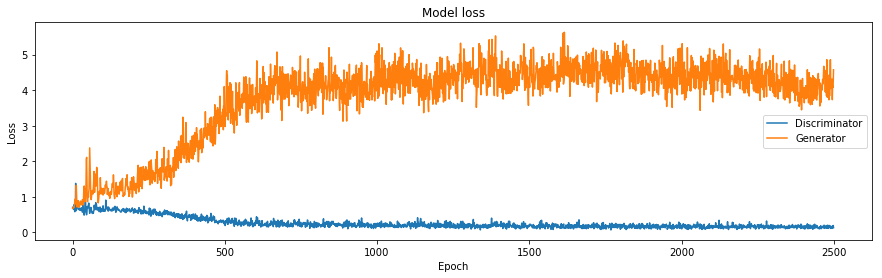

In [44]:
# Model loss 
plt.figure(figsize=(15, 4))
plt.plot(d_loss_list)
plt.plot(g_loss_list)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Generator'], loc='center right')
plt.show()

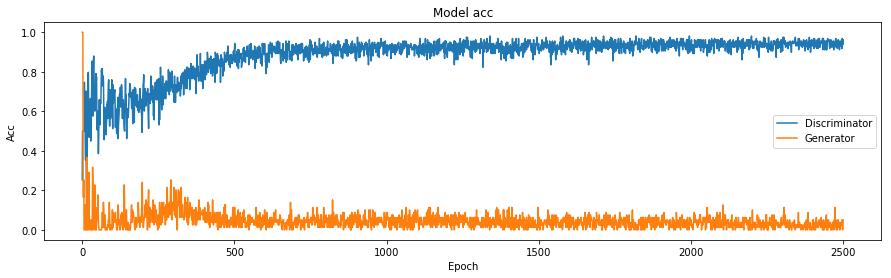

In [45]:
# Model acc 
plt.figure(figsize=(15, 4))
plt.plot(d_acc_list)
plt.plot(g_acc_list)
plt.title('Model acc')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Generator'], loc='center right')
plt.show()

## t-SNE를 통한 시각화 (원본 소수 클래스, 생성된 소수 클래스)

(158, 2)


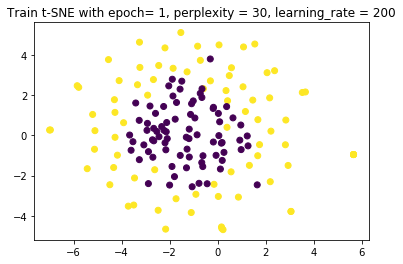

(158, 2)


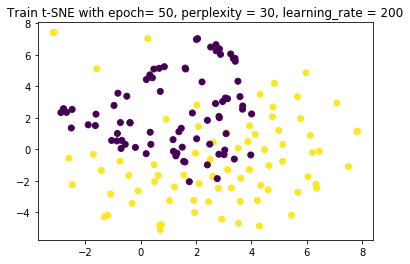

(158, 2)


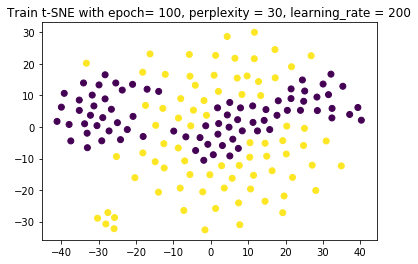

(158, 2)


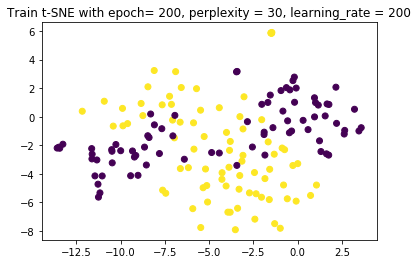

(158, 2)


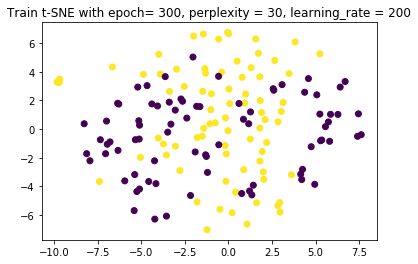

(158, 2)


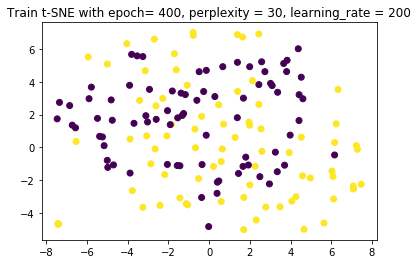

(158, 2)


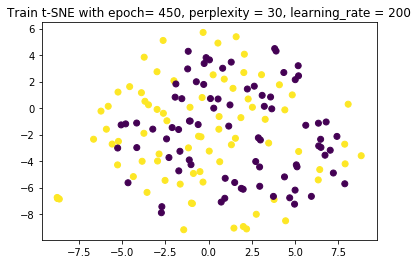

(158, 2)


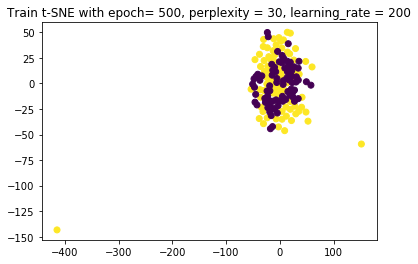

(158, 2)


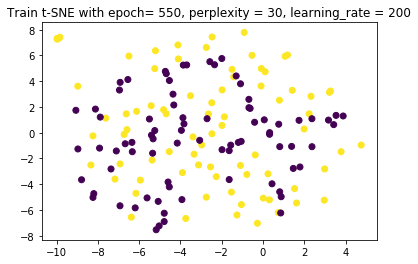

(158, 2)


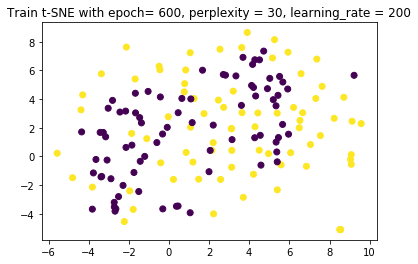

(158, 2)


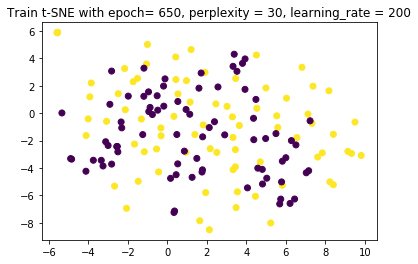

(158, 2)


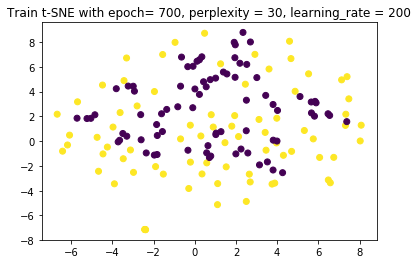

(158, 2)


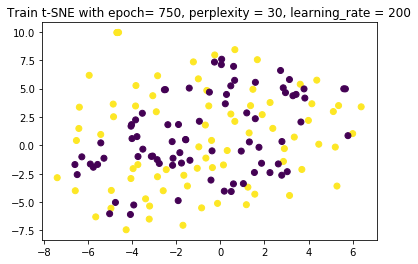

(158, 2)


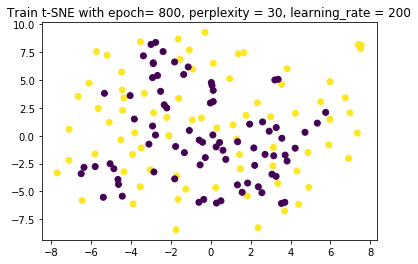

(158, 2)


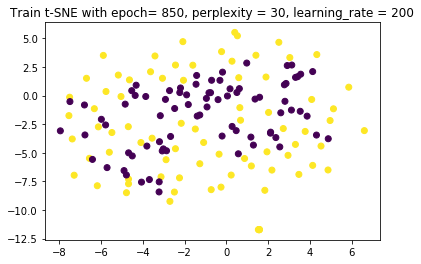

(158, 2)


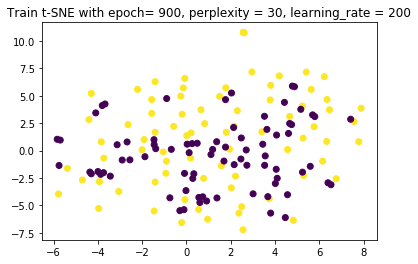

(158, 2)


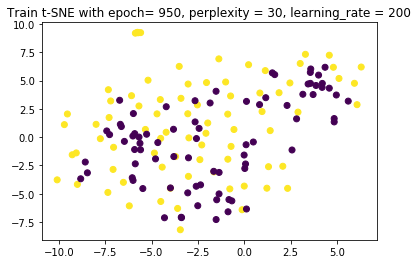

(158, 2)


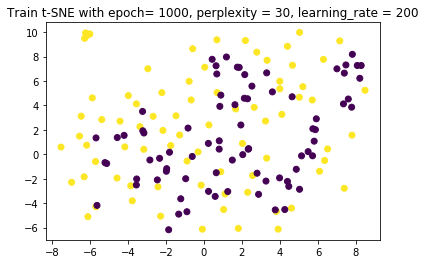

(158, 2)


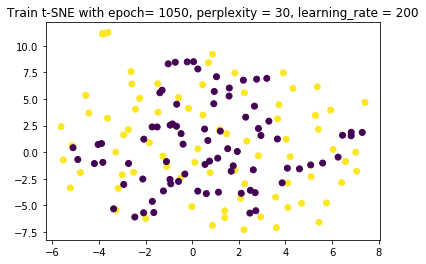

(158, 2)


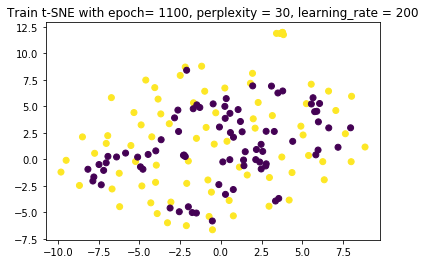

(158, 2)


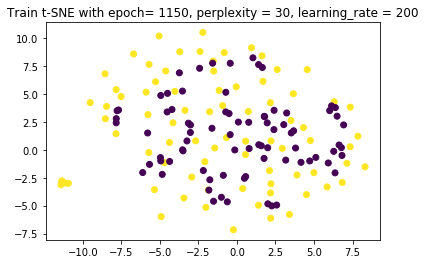

(158, 2)


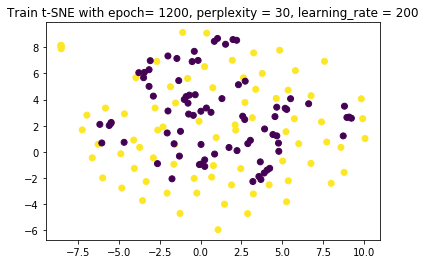

(158, 2)


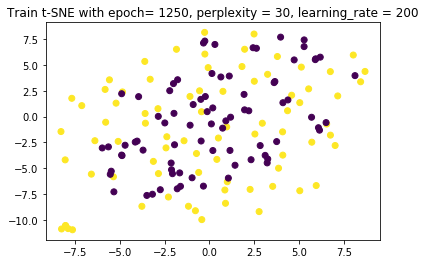

(158, 2)


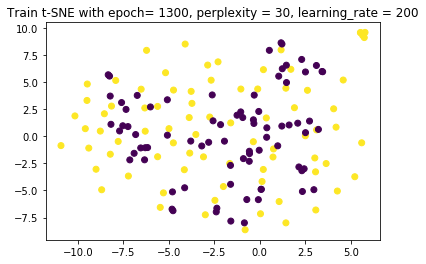

(158, 2)


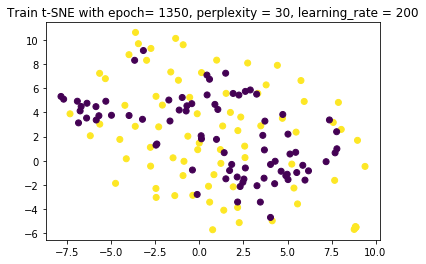

(158, 2)


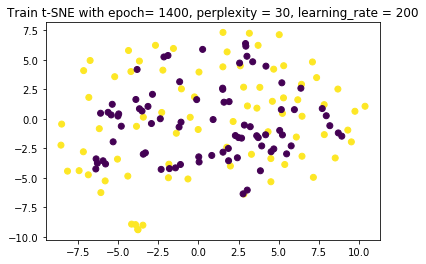

(158, 2)


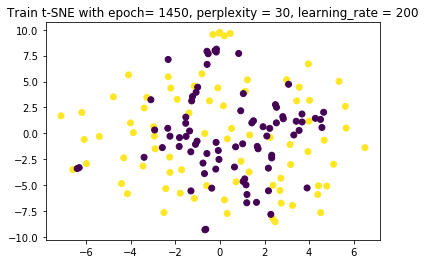

(158, 2)


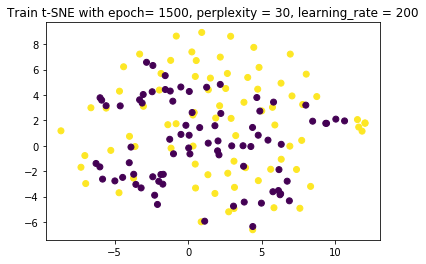

(158, 2)


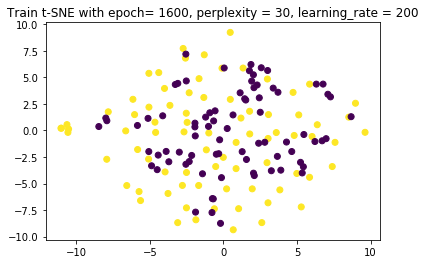

(158, 2)


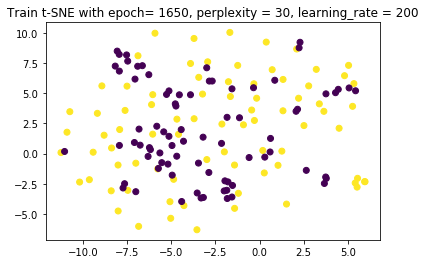

(158, 2)


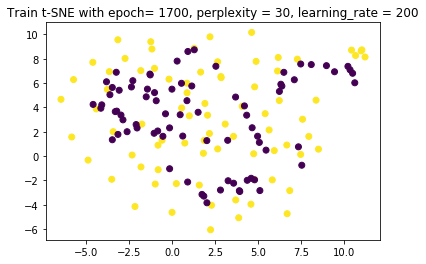

(158, 2)


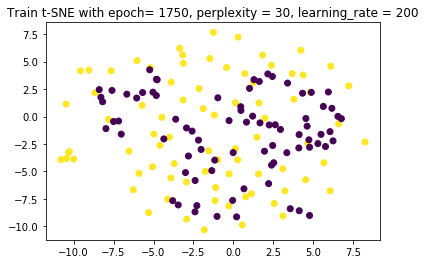

(158, 2)


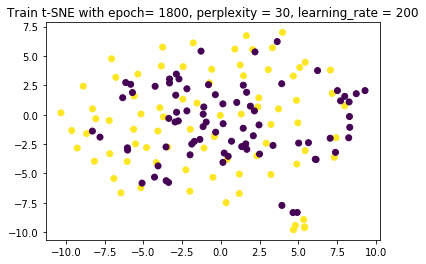

(158, 2)


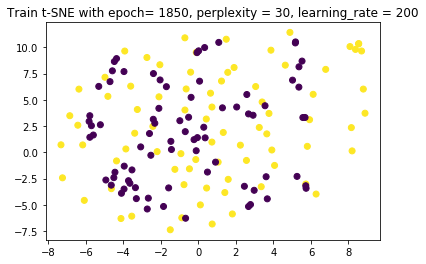

(158, 2)


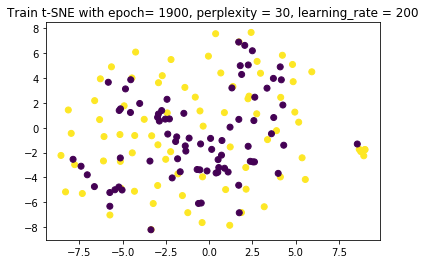

(158, 2)


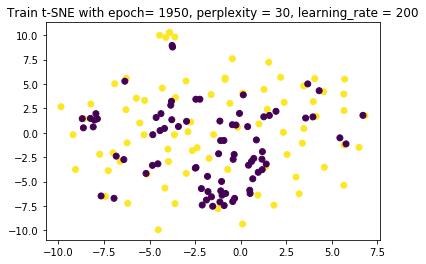

(158, 2)


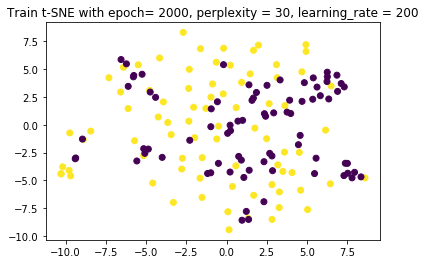

(158, 2)


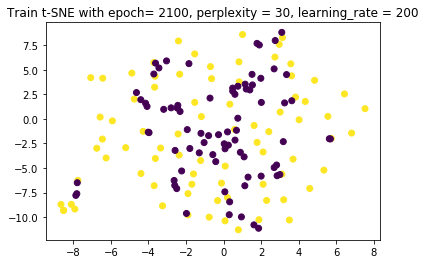

(158, 2)


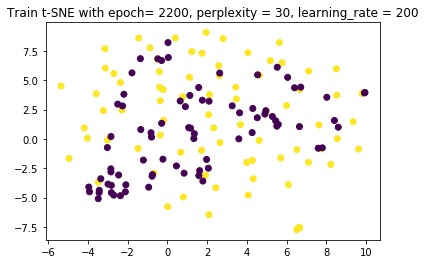

(158, 2)


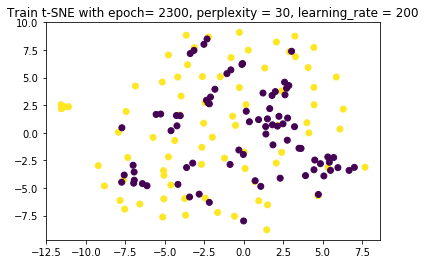

(158, 2)


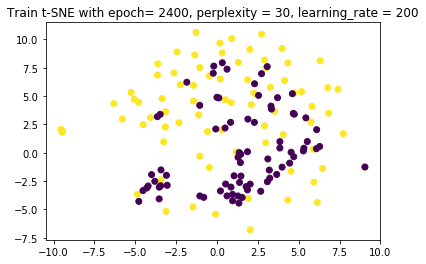

(158, 2)


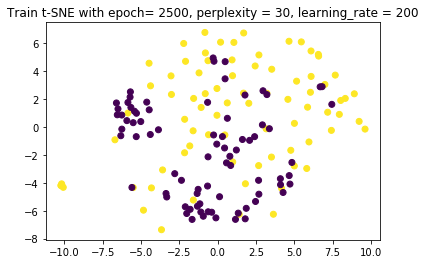

In [46]:
epochs_list = [1, 50, 100, 200, 300, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950,
               1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1600, 1650, 1700,
               1750, 1800, 1850, 1900, 1950, 2000, 2100, 2200, 2300, 2400, 2500]

for epoch in epochs_list :
    
    gan_generated_data = pd.read_csv("../../mypydata/generatedData2/gan_generated_data_epoch_%d.csv" % epoch)
    gan_generated_data[590] = 0
    
    combined_real_fake = np.concatenate((df_minority_class, gan_generated_data), axis=0)
    combined_real_fake = pd.DataFrame(data = combined_real_fake)
    
    features = combined_real_fake.values[:, 0:gan_generated_data.shape[1]-1]
    label = combined_real_fake.values[:, gan_generated_data.shape[1]-1]
    
    perplexity_list = [30]
    learning_rate_list = [200]

    for perplexity in perplexity_list :
    
        for learning_rate in learning_rate_list :
        
            model = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, random_state=seed) 
            features_embedded  = model.fit_transform(features)
            print(features_embedded.shape)
        
            # 2차원 형태로 차원 축소 된다.
            xs = features_embedded[:,0]
            ys = features_embedded[:,1]
            title_tr = 'Train t-SNE with epoch= {}, perplexity = {}, learning_rate = {}'.format(epoch, perplexity, learning_rate)
            plt.scatter(xs, ys, c=label)
            plt.title(title_tr)
            plt.show()

900~1300